<a href="https://colab.research.google.com/github/jiseokshin/FIT3181_A2/blob/main/FIT3181_DeepLearning_Assignment2_Notebook2_%5BRNNs%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#0b486b">  FIT3181: Deep Learning (2025) - Assignment 2 (Section II)</font>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# <font color="#0b486b">  Student Information</font>
***
Surname: **Shin**  <br/>
Firstname: **Jiseok**    <br/>
Student ID: **[33095310]**    <br/>
Email: **[jshi0072@student.monash.edu]**    <br/>
Your tutorial time: **[Thursday 2pm-5pm]**    <br/>
***

# <font color="0b486b">Assignment 2 – Deep Learning for Sequential Data</font>
### Due: <font color="red">11:55pm Sunday, 26 October 2025</font> (FIT3181)

#### <font color="red">Important note:</font> This is an **individual** assignment. It contributes **20%** to your final mark. Read the assignment instructions carefully.

## <font color="#0b486b">Assignment 2's Organization</font>
This assignment 2 has two (2) sections:
- Section 1: Fundamentals of RNNs (10 marks).
- Section 2: Deep Learning for Sequential Data (90 marks). This section is further divided into 4 parts.

The assignment 2 is organized in three (3) notebooks:
- Notebook 1 ([link](https://colab.research.google.com/drive/1hTS6bWz6gU-lvi1qkIhrtQnJ3tzxRPFK?usp=sharing)) [Total: 30 marks] includes Section 1 as well as Part 1 and Part 2 of Section 2.
- Notebook 2 (this notebook) [Total: 40 marks] includes Part 3 of Section 2.
- Notebook 3 ([link](https://colab.research.google.com/drive/1JfMZeCkkvjZ5LvKNV-UnR10pl-RogMgF?usp=sharing)) [Total: 30 marks] includes Part 4 of Section 2.


## <font color="#0b486b">What to submit</font>

This assignment is to be completed individually and submitted to Moodle unit site. **By the due date, you are required to submit one  <font color="red; font-weight:bold">single zip file, named xxx_assignment02_solution.zip</font> where `xxx` is your student ID, to the corresponding Assignment (Dropbox) in Moodle**. You can use Google Colab to do Assignment 2 but you need to save it to an `*.ipynb` file to submit to the unit Moodle.

**More importantly, if you use Google Colab to do this assignment, you need to first make a copy of this notebook on your Google drive**.

***For example, if your student ID is <font color="red; font-weight:bold">12356</font>, then gather all of your assignment solutions to a folder, create a zip file named <font color="red; font-weight:bold">123456_assignment02_solution.zip</font> and submit this file.***

Within this zip folder, you **must** submit the following files <u>for each part</u>:
1.	**`FIT3181_DeepLearning_Assignment2_Official[Main].ipynb`**:  this is your Python notebook solution source file.
1.	**`FIT3181_DeepLearning_Assignment2_Official[Main].html`**: this is the output of your Python notebook solution *exported* in HTML format.
1. **`FIT3181_DeepLearning_Assignment2_Official[RNNs].ipynb`**
1. **`FIT3181_DeepLearning_Assignment2_Official[RNNs].html`**
1. **`FIT3181_DeepLearning_Assignment2_Official[Transformers].ipynb`**
1. **`FIT3181_DeepLearning_Assignment2_Official[Transformers].html`**
1.	Any **extra files or folder** needed to complete your assignment (e.g., images used in your answers).



## Section 2: Deep Learning for Sequential Data

### <font color="#0b486b">Set random seeds</font>

We start with importing PyTorch and NumPy and setting random seeds for PyTorch and NumPy. You can use any seeds you prefer.

In [1]:
import os
import torch
import random
import requests
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
import os
from six.moves.urllib.request import urlretrieve
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all(seed=1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## <font color="#0b486b">Download and preprocess the data</font>

<div style="text-align: right"><font color="red; font-weight:bold"><span></div>

The dataset we use for this assignment is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR),
- entity (ENTY),
- description (DESC),
- human (HUM),
- location (LOC) and
- numeric (NUM).

In this assignment, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this assignment. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager* class before proceeding to answer the questions.

In [3]:
class DataManager:
    """
    This class manages and preprocesses a simple text dataset for a sentence classification task.

    Attributes:
        verbose (bool): Controls verbosity for printing information during data processing.
        max_sentence_len (int): The maximum length of a sentence in the dataset.
        str_questions (list): A list to store the string representations of the questions in the dataset.
        str_labels (list): A list to store the string representations of the labels in the dataset.
        numeral_labels (list): A list to store the numerical representations of the labels in the dataset.
        numeral_data (list): A list to store the numerical representations of the questions in the dataset.
        random_state (int): Seed value for random number generation to ensure reproducibility.
            Set this value to a specific integer to reproduce the same random sequence every time. Defaults to 6789.
        random (np.random.RandomState): Random number generator object initialized with the given random_state.
            It is used for various random operations in the class.

    Methods:
        maybe_download(dir_name, file_name, url, verbose=True):
            Downloads a file from a given URL if it does not exist in the specified directory.
            The directory and file are created if they do not exist.

        read_data(dir_name, file_names):
            Reads data from files in a directory, preprocesses it, and computes the maximum sentence length.
            Each file is expected to contain rows in the format "<label>:<question>".
            The labels and questions are stored as string representations.

        manipulate_data():
            Performs data manipulation by tokenizing, numericalizing, and padding the text data.
            The questions are tokenized and converted into numerical sequences using a tokenizer.
            The sequences are padded or truncated to the maximum sequence length.

        train_valid_test_split(train_ratio=0.9):
            Splits the data into training, validation, and test sets based on a given ratio.
            The data is randomly shuffled, and the specified ratio is used to determine the size of the training set.
            The string questions, numerical data, and numerical labels are split accordingly.
            TensorFlow `Dataset` objects are created for the training and validation sets.


    """

    def __init__(self, verbose=True, random_state=6789):
        self.verbose = verbose
        self.max_sentence_len = 0
        self.str_questions = list()
        self.str_labels = list()
        self.numeral_labels = list()
        self.maxlen = None
        self.numeral_data = list()
        self.random_state = random_state
        self.random = np.random.RandomState(random_state)

    @staticmethod
    def maybe_download(dir_name, file_name, url, verbose=True):
        if not os.path.exists(dir_name):
            os.mkdir(dir_name)
        if not os.path.exists(os.path.join(dir_name, file_name)):
            urlretrieve(url + file_name, os.path.join(dir_name, file_name))
        if verbose:
            print("Downloaded successfully {}".format(file_name))

    def read_data(self, dir_name, file_names):
        self.str_questions = list()
        self.str_labels = list()
        for file_name in file_names:
            file_path= os.path.join(dir_name, file_name)
            with open(file_path, "r", encoding="latin-1") as f:
                for row in f:
                    row_str = row.split(":")
                    label, question = row_str[0], row_str[1]
                    question = question.lower()
                    self.str_labels.append(label)
                    self.str_questions.append(question[0:-1])
                    if self.max_sentence_len < len(self.str_questions[-1]):
                        self.max_sentence_len = len(self.str_questions[-1])

        # turns labels into numbers
        le = preprocessing.LabelEncoder()
        le.fit(self.str_labels)
        self.numeral_labels = np.array(le.transform(self.str_labels))
        self.str_classes = le.classes_
        self.num_classes = len(self.str_classes)
        if self.verbose:
            print("\nSample questions and corresponding labels... \n")
            print(self.str_questions[0:5])
            print(self.str_labels[0:5])

    def manipulate_data(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        vocab = self.tokenizer.get_vocab()
        self.word2idx = {w: i for i, w in enumerate(vocab)}
        self.idx2word = {i:w for w,i in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

        token_ids = []
        num_seqs = []
        for text in self.str_questions:  # iterate over the list of text
          text_seqs = self.tokenizer.tokenize(str(text))  # tokenize each text individually
          # Convert tokens to IDs
          token_ids = self.tokenizer.convert_tokens_to_ids(text_seqs)
          # Convert token IDs to a tensor of indices using your word2idx mapping
          seq_tensor = torch.LongTensor(token_ids)
          num_seqs.append(seq_tensor)  # append the tensor for each sequence

        # Pad the sequences and create a tensor
        if num_seqs:
          self.numeral_data = pad_sequence(num_seqs, batch_first=True)  # Pads to max length of the sequences
          self.num_sentences, self.maxlen = self.numeral_data.shape

    def train_valid_test_split(self, train_ratio=0.8, test_ratio = 0.1):
        train_size = int(self.num_sentences*train_ratio) +1
        test_size = int(self.num_sentences*test_ratio) +1
        valid_size = self.num_sentences - (train_size + test_size)
        data_indices = list(range(self.num_sentences))
        random.shuffle(data_indices)
        self.train_str_questions = [self.str_questions[i] for i in data_indices[:train_size]]
        self.train_numeral_labels = self.numeral_labels[data_indices[:train_size]]
        train_set_data = self.numeral_data[data_indices[:train_size]]
        train_set_labels = self.numeral_labels[data_indices[:train_size]]
        train_set_labels = torch.from_numpy(train_set_labels)
        train_set = torch.utils.data.TensorDataset(train_set_data, train_set_labels)
        self.test_str_questions = [self.str_questions[i] for i in data_indices[-test_size:]]
        self.test_numeral_labels = self.numeral_labels[data_indices[-test_size:]]
        test_set_data = self.numeral_data[data_indices[-test_size:]]
        test_set_labels = self.numeral_labels[data_indices[-test_size:]]
        test_set_labels = torch.from_numpy(test_set_labels)
        test_set = torch.utils.data.TensorDataset(test_set_data, test_set_labels)
        self.valid_str_questions = [self.str_questions[i] for i in data_indices[train_size:-test_size]]
        self.valid_numeral_labels = self.numeral_labels[data_indices[train_size:-test_size]]
        valid_set_data = self.numeral_data[data_indices[train_size:-test_size]]
        valid_set_labels = self.numeral_labels[data_indices[train_size:-test_size]]
        valid_set_labels = torch.from_numpy(valid_set_labels)
        valid_set = torch.utils.data.TensorDataset(valid_set_data, valid_set_labels)
        self.train_loader = DataLoader(train_set, batch_size=64, shuffle=True) # you can change the batch size if needed
        self.test_loader = DataLoader(test_set, batch_size=64, shuffle=False) # you can change the batch size if needed
        self.valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False) # you can change the batch size if needed

In [4]:
print('Loading data...')
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager()
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [5]:
dm.manipulate_data()
dm.train_valid_test_split(train_ratio=0.8, test_ratio = 0.1)

In [6]:
for x, y in dm.train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 36]) torch.Size([64])


We now declare the `BaseTrainer` class, which will be used later to train the subsequent deep learning models for text data.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader):
        self.model = model
        self.criterion = criterion  #the loss function
        self.optimizer = optimizer  #the optimizer
        self.train_loader = train_loader  #the train loader
        self.val_loader = val_loader  #the valid loader

    #the function to train the model in many epochs
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            train_loss, train_accuracy = self.train_one_epoch()
            val_loss, val_accuracy = self.validate_one_epoch()
            print(
                f'{self.num_batches}/{self.num_batches} - train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy*100:.4f}% \
                - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy*100:.4f}%')

    #train in one epoch, return the train_acc, train_loss
    def train_one_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0
        for i, data in enumerate(self.train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = correct / total
        train_loss = running_loss / self.num_batches
        return train_loss, train_accuracy

    #evaluate on a loader and return the loss and accuracy
    def evaluate(self, loader):
        self.model.eval()
        loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for data in loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        loss = loss / len(self.val_loader)
        return loss, accuracy

    #return the val_acc, val_loss, be called at the end of each epoch
    def validate_one_epoch(self):
      val_loss, val_accuracy = self.evaluate(self.val_loader)
      return val_loss, val_accuracy

## <font color="#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</font>

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 40 marks]<span></div>

### <font color="#0b486b">3.1. RNNs with different cell types</font> ###

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 16 marks]<span></div>

#### <font color="red">**Question 3.1.1**</font>
**In this part, you need to construct a vanilla RNN using PyTorch to learn from the dataset of interest. Basically, you are required to construct the class `BaseRNN` with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.
- The `build` method/function aims to build the architecture of our RNNs.
- Attribute `output_type (self.output_type)` has three values which are `"last_state"`, `"mean"`, or `"max"`, indicating we use the last hidden state, the mean of all hidden states, or the max of all hidden states on the last RNN hidden layer for gaining the 2D tensor $\left[batch\_size, state\_sizes[-1] \right]$ on which we conduct one linear layer for making prediction.   

<div style="text-align: right"><font color="red">[10 marks]</font></div>

In [ ]:
class BaseRNN(nn.Module):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type = "mean", data_manager=None):
        super().__init__()
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.output_type = output_type
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size

    # return the corresponding memory cell
    @staticmethod
    def get_layer(cell_type='gru', input_size=128, state_size=128):
        if cell_type == 'gru':
            return # Insert your code here
        elif cell_type == 'lstm':
            return # Insert your code here
        else:
            return  # Insert your code here

    def build(self):
        # Insert your code here


    def forward(self, x):
        # Insert your code here


#### <font color="red">**Question 3.1.2**</font>
**Train the models with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.**

<div style="text-align: right"><font color="red">[2 marks]</font></div>

a) For `output_type = "mean"`

In [ ]:
#Insert your code here
base_rnn =
criterion =
optimizer =

BaseRNN(
  (layers): ModuleList(
    (0): Embedding(30522, 128)
    (1): RNN(128, 64, batch_first=True)
    (2): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

b) For `output_type = "max"`

In [ ]:
#Insert your code here
base_rnn =
criterion =
optimizer =

BaseRNN(
  (layers): ModuleList(
    (0): Embedding(30522, 128)
    (1): RNN(128, 64, batch_first=True)
    (2): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

c) For `output_type = "last_state"`

In [ ]:
#Insert your code here
base_rnn =
criterion =
optimizer =

BaseRNN(
  (layers): ModuleList(
    (0): Embedding(30522, 128)
    (1): RNN(128, 64, batch_first=True)
    (2): RNN(64, 128, batch_first=True)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
trainer = BaseTrainer(model= base_rnn, criterion=criterion, optimizer=optimizer, train_loader=dm.train_loader, val_loader=dm.valid_loader)
trainer.fit(num_epochs=30)

#### <font color="red">**Question 3.1.3**</font>
**Train the models with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.** You should follow the structure of Question 3.1.2.

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [ ]:
#Insert your code here
lstm_rnn =

In [ ]:
#Insert your code here
lstm_rnn =

In [ ]:
#Insert your code here
lstm_rnn =

#### <font color="red">**Question 3.1.4**</font>
**Train the models with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$ and with three ouput types.** You should follow the structure of Question 3.1.2.

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [ ]:
#Insert your code here
gru_rnn =

In [ ]:
#Insert your code here
gru_rnn =

In [ ]:
#Insert your code here
gru_rnn =

### <font color="#0b486b">3.2. RNNs with fine-tuning embedding matrix</font> ###

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <font color="red">**Question 3.2.1**</font>

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><font color="red">[8 marks]</font></div>

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
class RNN(BaseRNN):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type = 'mean', data_manager=None,
                 run_mode='scratch', embed_model='glove-wiki-gigaword-100'):
        super().__init__(cell_type, embed_size, state_sizes, output_type, data_manager)
        self.run_mode = run_mode
        self.embed_model = embed_model
        # Create a folder to save the embedding matrix
        if not os.path.exists("embeddings"):
          os.makedirs("embeddings")
        self.embed_path = "embeddings/E.npy"
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.word2idx = data_manager.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

    def build_embedding_matrix(self):
        # Insert your code here. Your code should allow for saving the embedding matrix in ``self.embed_path'' (as numpy array) for future retrieval.

    def build(self):
        # Insert your code here to override the 'build' method of BaseRNN


#### <font color="red">**Question 3.2.2**</font>

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should set fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><font color="red">[4 marks]</font></div>

In [ ]:
# Insert your code here


In [ ]:
# Insert your code here


In [ ]:
# Insert your code here


Write your comments on the results here (maximum 150 words)




### <font color="#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</font> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the output hidden state which is computed by aggregating $\textbf{h}^{1:T}_L$ following $3$ different `output_type` as above. On top of this concatenation, we conduct the output layer with the softmax activation.**

<div style="text-align: right"><font color="red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

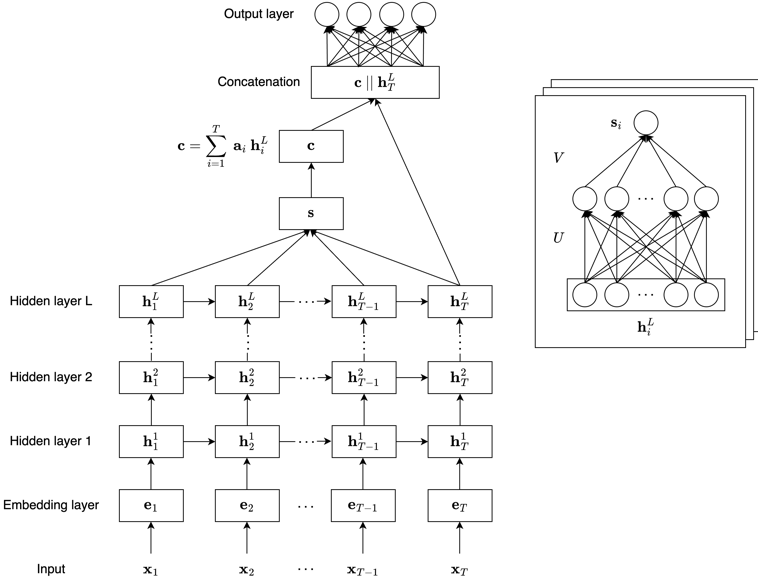

#### <font color="red">**Question 3.3.1**</font>

**We declare the  layer `MyAttention` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def forward(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><font color="red">[4 marks]</font></div>

In [ ]:
import torch.nn.functional as F

class MyAttention(nn.Module):
    def __init__(self, output_length=50):
        super().__init__()
        # Insert your code here
        self.output_length = output_length

    # all_states is the collection of all hidden states and last_state is the last hidden state
    def forward(self, all_states, last_state):
        # Insert your code here
        return context_vector

We now test `MyAttention`.

In [ ]:
batch_size = 10
seq_length = 20
state_size = 5
all_states = torch.randn(batch_size, seq_length, state_size).to(device)
last_state = all_states[:, -1, :].to(device)
attention = MyAttention()
context_vector = attention(all_states, last_state)
print(all_states.shape)
print(last_state.shape)
print(context_vector.shape)

torch.Size([10, 20, 5])
torch.Size([10, 5])
torch.Size([10, 5])


#### <font color="red">**Question 3.3.2**</font>

**You are required to extend the class `BaseRNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><font color="red">[6 marks]</font></div>

In [ ]:
class AttentionRNN(BaseRNN):
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 128], output_type = "mean",data_manager=None):
        super().__init__(cell_type, embed_size, state_sizes, output_type, data_manager)

    def build(self):
        # Insert your code here to override the method build() in BaseRNN class.


    def forward(self, x):
        # Insert your code here to override the method forward() in BaseRNN class.


#### <font color="red">**Question 3.3.3**</font>

**Conduct the experiment to test the above Attention RNN.**

<div style="text-align: right"><font color="red">[2 marks]</font></div>

In [ ]:
#Insert your code here
attn_rnn =
criterion =
optimizer =
trainer =
trainer.fit(num_epochs=30)